In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.models as models
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFilter

ModuleNotFoundError: No module named 'tensorboard'

In [3]:
# Parameters
NUM_FILES = 1000
NUM_CLASSES = 6 
IMG_SIZE = (224, 224)  
BATCH_SIZE = 32  
EPOCHS = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
class SpectrogramDataset(Dataset):
    # don't understand data loaders
    def __init__(self, spectrograms, _labels, _transform=None) -> None:
        self.spectrograms = spectrograms
        self.labels = _labels
        self.transform = _transform

    def __len__(self) -> int:
        return len(self.spectrograms)

    def __getitem__(self, idx) -> tuple:
        spectrogram = self.spectrograms[idx]
        label = self.labels[idx]
        if self.transform:
            spectrogram = Image.fromarray(spectrogram)
            if spectrogram.mode != 'RGB':
                spectrogram = spectrogram.convert('RGB')
            spectrogram = self.transform(spectrogram)
        return spectrogram, label


def read_data(data_folder, num_files=None) -> tuple[list, list, pd.DataFrame, pd.DataFrame]:
    train_spec_folder = os.path.join(data_folder, 'train_spectrograms')
    test_spec_folder = os.path.join(data_folder, 'test_spectrograms')

    def read_npy_folder(folder_path, n_files=None) -> tuple[list, list]:
        arrays = []
        filenames = []
        files_to_read = os.listdir(folder_path)[:n_files] if n_files else os.listdir(folder_path)
        for file in files_to_read:
            if file.endswith('.npy'):
                file_path = os.path.join(folder_path, file)
                array = np.load(file_path)
                arrays.append(array)
                filenames.append(int(file.split('.')[0]))  # Extracting ID from filename
        print(f"Read {len(arrays)} files from {folder_path}.")
        return arrays, filenames

    _train_spec, train_ids = read_npy_folder(train_spec_folder, num_files)
    _test_spec, test_ids = read_npy_folder(test_spec_folder)

    _train_labels = pd.read_csv(os.path.join(data_folder, 'train.csv'))
    _test_labels = pd.read_csv(os.path.join(data_folder, 'test.csv'))

    # Filter labels based on matching ID
    _train_labels = _train_labels[_train_labels['spectrogram_id'].isin(train_ids)]
    _test_labels = _test_labels[_test_labels['spectrogram_id'].isin(test_ids)]

    # Limit the number of labels to match the available data
    _train_labels = _train_labels.head(len(_train_spec))
    _test_labels = _test_labels.head(len(_test_spec))

    return _train_spec, _test_spec, _train_labels, _test_labels

# Define your model architecture
class CNNModel(nn.Module):
    def __init__(self, num_classes) -> None:
        super(CNNModel, self).__init__()
        # Load a pre-trained ResNet model with ImageNet weights
        resnet = models.resnet18(weights='IMAGENET1K_V1')
        # Remove the fully connected layer and replace it with custom layers
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        # Add custom fully connected layers
        self.fc1 = nn.Linear(resnet.fc.in_features, 128)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        self.batchnorm = nn.BatchNorm1d(128)
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.batchnorm(x)
        x = self.fc2(x)
        return x

In [5]:
# Read data
train_spec, test_spec, train_labels, test_labels = read_data('data/npy_data/npy_data', num_files=NUM_FILES)

Read 1000 files from data/npy_data/npy_data\train_spectrograms.
Read 1 files from data/npy_data/npy_data\test_spectrograms.


In [6]:
len(train_spec),train_labels.shape

(1000, (1000, 15))

In [7]:
Xt, Xv, yt, yv = train_test_split(
    train_spec, train_labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


In [8]:
y_train = yt.iloc[:, 9:]
y_val = yv.iloc[:, 9:]
pd.DataFrame(y_train)

,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
298,4,0,2,0,9,1
6095,0,0,0,0,0,12
6255,2,2,0,0,0,1
6117,3,0,0,0,0,0
51100,0,0,0,0,0,17
...,...,...,...,...,...,...
5666,0,0,2,0,2,0
5830,0,0,0,2,2,11
51124,0,0,0,3,0,0
5995,0,0,0,0,3,0


In [9]:
y_train = y_train.apply(pd.to_numeric, errors='coerce')
y_train.fillna(0, inplace=True)
y_train_normalized = y_train.div(y_train.sum(axis=1), axis=0)
weights = y_train.sum(axis=1)  # Calculate weights based on number of voters per row
y_train_normalized = y_train_normalized.mul(weights, axis=0)
y_train_normalized = y_train_normalized.div(y_train_normalized.sum(axis=1), axis=0)
y_train = torch.tensor(y_train_normalized.values, dtype=torch.float32)

In [10]:
y_val = y_val.apply(pd.to_numeric, errors='coerce')
y_val.fillna(0, inplace=True)
y_val_normalized = y_val.div(y_val.sum(axis=1), axis=0)
weights = y_val.sum(axis=1)
y_val_normalized = y_val_normalized.mul(weights, axis=0)
y_val_normalized = y_val_normalized.div(y_val_normalized.sum(axis=1), axis=0)
y_val = torch.tensor(y_val_normalized.values, dtype=torch.float32)

In [11]:
np.allclose(y_train_normalized.sum(axis=1), 1),np.allclose(y_val_normalized.sum(axis=1), 1)

(True, True)

In [12]:
model = CNNModel(num_classes=NUM_CLASSES)
model.to(device)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  
    transforms.ToTensor(),       
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

train_dataset = SpectrogramDataset(Xt, y_train, _transform=transform)
val_dataset = SpectrogramDataset(Xv, y_val, _transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

criterion = nn.KLDivLoss(reduction='batchmean')
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
len(train_dataset),len(val_dataset)

(800, 200)

In [14]:
# callbacks


In [15]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  
        outputs = model(inputs)
        loss = criterion(F.log_softmax(outputs, dim=1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)  # Store training loss for this epoch
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  
            outputs = model(inputs)
            loss = criterion(F.log_softmax(outputs, dim=1), labels)
            validation_loss += loss.item() * inputs.size(0)

    epoch_val_loss = validation_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)  # Store validation loss for this epoch
    
    if epoch % 2 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Validation Loss: {epoch_val_loss:.4f}")


Epoch 1/25, Training Loss: 1.5689
Epoch 1/25, Validation Loss: 587.8748
Epoch 3/25, Training Loss: 1.4480
Epoch 3/25, Validation Loss: 3.6557
Epoch 5/25, Training Loss: 1.4892
Epoch 5/25, Validation Loss: 2.3749
Epoch 7/25, Training Loss: 1.5317
Epoch 7/25, Validation Loss: 2.0434
Epoch 9/25, Training Loss: 1.5350
Epoch 9/25, Validation Loss: 11.0226
Epoch 11/25, Training Loss: 1.7429
Epoch 11/25, Validation Loss: 2.6825
Epoch 13/25, Training Loss: 1.6043
Epoch 13/25, Validation Loss: 1.7556
Epoch 15/25, Training Loss: 1.6241
Epoch 15/25, Validation Loss: 1.4898
Epoch 17/25, Training Loss: 1.6367
Epoch 17/25, Validation Loss: 1.9048
Epoch 19/25, Training Loss: 1.7128
Epoch 19/25, Validation Loss: 2.0493
Epoch 21/25, Training Loss: 1.5788
Epoch 21/25, Validation Loss: 1.8451
Epoch 23/25, Training Loss: 1.7487
Epoch 23/25, Validation Loss: 1.8630
Epoch 25/25, Training Loss: 1.6709
Epoch 25/25, Validation Loss: 2.1100


In [16]:
torch.save(model, os.getcwd() + "/saved_models/model_resnet18_2")
# model = torch.load(os.getcwd() + "/saved_models/model")

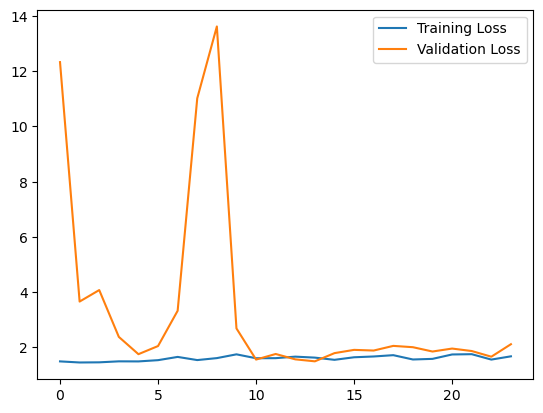

In [18]:
import  matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()